In [1]:
import pickle
import numpy as np
import matplotlib.pylab as plt
import uproot
from sklearn.metrics import confusion_matrix

In [2]:
def return_accuracy(predict1,predict2,validation):
    mass_predict1 = []
    for i in predict1:
        if i <2.5:
            mass_predict1.append(1)
        else:
            mass_predict1.append(4)
    cm=confusion_matrix(validation,mass_predict1)

    mass_predict4 = []
    for i in predict2:
        if i <2.5:
            mass_predict4.append(1)
        else:
            mass_predict4.append(4)
    cm1=confusion_matrix(validation,mass_predict4)
    
    return cm[0][0]/np.sum(cm[0]),cm1[1][1]/np.sum(cm1[1]),np.array(mass_predict1),np.array(mass_predict4)

In [3]:
file = uproot.open('/home/andy/12632.root')
file2 = uproot.open('/home/andy/12633.root')

In [4]:
cut_model = pickle.load((open('cut_model.sav','rb')))
model1 =  pickle.load((open('model.sav','rb')))

In [5]:
S125_1 = np.log10(file['LaputopParams']['s125'].array())
S125_2 = np.log10(file2['LaputopParams']['s125'].array())
A1 = file['CurvatureOnlyParams']['A'].array()
A2 = file2['CurvatureOnlyParams']['A'].array()
D1 = file['CurvatureOnlyParams']['D'].array()
D2 = file2['CurvatureOnlyParams']['D'].array()
N1 = file['CurvatureOnlyParams']['N'].array()
N2 = file2['CurvatureOnlyParams']['N'].array()
beta1 = file['LaputopParams']['beta'].array()
beta2 = file2['LaputopParams']['beta'].array()
zenith1 = file['Laputop']['zenith'].array()
zenith2 = file2['Laputop']['zenith'].array()
energy1 = file['MCPrimary']['energy'].array()
energy2 = file2['MCPrimary']['energy'].array()
chi2_1 = file['CurvatureOnlyParams']['chi2_time'].array()
chi2_2 = file2['CurvatureOnlyParams']['chi2_time'].array()

slc_charge1 = file['LaputopSLCPE']['charge'].array()
slc_charge2 = file2['LaputopSLCPE']['charge'].array()

slc_charge1 = [np.sum(i) for i in slc_charge1]
slc_charge2 = [np.sum(i) for i in slc_charge2]

hlc_charge1 = file['LaputopHLCPE']['charge'].array()
hlc_charge2 = file2['LaputopHLCPE']['charge'].array()

hlc_charge1 = [np.sum(i) for i in hlc_charge1]
hlc_charge2 = [np.sum(i) for i in hlc_charge2]

Qtot1 = [i+j for i,j in zip(slc_charge1,hlc_charge1)]
Qtot2 = [i+j for i,j in zip(slc_charge2,hlc_charge2)]

mass1 = [1 for i in range(len(Qtot1))]
mass2 = [4 for i in range(len(Qtot2))]

In [6]:
A = np.append(A1,A2)
D = np.append(D1,D2)
N = np.append(N1,N2)
S125 = np.append(S125_1,S125_2)
beta = np.log10(np.append(beta1,beta2))
chi2 = np.log10(np.append(chi2_1,chi2_2))
zenith = np.cos(np.append(zenith1,zenith2))
zenith_new = np.append(zenith1,zenith2)
mass = np.append(mass1,mass2)
slc_charge = np.append(slc_charge1,slc_charge2)
hlc_charge = np.append(hlc_charge1,hlc_charge2)
qtot = np.append(Qtot1,Qtot2)

hlc_charge = np.log10(hlc_charge)
qtot = np.log10(qtot)

energy = np.append(energy1,energy2)
print(len(energy))

74114


/home/andy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/andy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


In [7]:
A = A[np.isfinite(chi2)]
D = D[np.isfinite(chi2)]
S125 = S125[np.isfinite(chi2)]
beta = beta[np.isfinite(chi2)]
chi2_new = chi2[np.isfinite(chi2)]
zenith = zenith[np.isfinite(chi2)]
mass = mass[np.isfinite(chi2)]
energy = np.log10(energy[np.isfinite(chi2)])
slc_charge = np.array(slc_charge)[np.isfinite(chi2)]
hlc_charge = np.array(hlc_charge)[np.isfinite(chi2)]
qtot = np.array(qtot)[np.isfinite(chi2)]
zenith_new = np.array(zenith_new)[np.isfinite(chi2)]

In [8]:
mask = cut_model.predict(list(zip(S125,slc_charge,hlc_charge,qtot,zenith,chi2_new)))

In [9]:
mask_new = []
for i in mask:
    if i < 0.5:
        mask_new.append(False)
    else:
        mask_new.append(True)

In [10]:
print(len(mass[mask_new]))

63358


In [11]:
input_variable2_old = np.array([np.append(np.append(np.append(np.append(np.append(i,j),k),l),m),n) for i,j,k,l,m,n in np.array(list(zip(D[mask_new],beta[mask_new],slc_charge[mask_new],S125[mask_new],zenith[mask_new],chi2_new[mask_new])))[10**chi2_new[mask_new]<3]])
output_new_old = np.array(mass[mask_new])[10**chi2_new[mask_new]<3]
energy_new = np.array(zenith_new[mask_new])[10**chi2_new[mask_new]<3]

In [12]:
prediction1 = model1.predict(input_variable2_old)
#prediction2 = model1.predict(input_variable2_old)
#prediction1 = (prediction1+prediction2)/2

In [13]:
data1 = np.array(list(zip(input_variable2_old,output_new_old)))
data2 = np.array(energy_new)
array_split = np.array_split(sorted(list(zip(data1,data2)),key=lambda x:x[1]),20)

In [14]:
x = []
y_proton = []
y_iron = []
for i in array_split:
    energy = list(zip(*i))[1]
    mass = list(zip(*list(zip(*i))[0]))[1]
    data = list(zip(*list(zip(*i))[0]))[0]
    prediction1 = model1.predict(data)
    #prediction2 = model2.predict(data)
    #prediction1 = (prediction1+prediction2)/2
    output_prediction = []
    for i in prediction1:
        if i < 2.5:
            output_prediction.append(1)
        else:
            output_prediction.append(4)
    
    cm = confusion_matrix(output_prediction,mass)
    x.append((max(energy)+min(energy))/2)
    y_proton.append(cm[0][0]/np.sum(cm[0]))
    y_iron.append(cm[1][1]/np.sum(cm[1]))

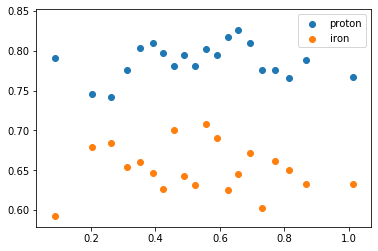

In [15]:
plt.scatter(x,y_proton,label='proton')
plt.scatter(x,y_iron,label='iron')
plt.legend()
plt.show()

In [16]:
print(y_iron,np.mean(y_iron))

[0.5930795847750865, 0.6789883268482491, 0.6844502277163305, 0.6534717715768981, 0.6602067183462532, 0.6470994475138122, 0.6266002844950214, 0.7005532503457814, 0.6427566807313643, 0.6318021201413427, 0.7075070821529745, 0.6904109589041096, 0.625086625086625, 0.6455516014234876, 0.6714677640603567, 0.6031957390146472, 0.6610878661087866, 0.6504782928623988, 0.6322097378277154, 0.6325878594249201] 0.6519295969678081


In [17]:
print(y_proton,np.mean(y_proton))

[0.7913322632423756, 0.7458659704090513, 0.7415437987857763, 0.7754569190600522, 0.8038528896672504, 0.8091787439613527, 0.7975077881619937, 0.7813504823151125, 0.7941640378548895, 0.7803921568627451, 0.8020344287949922, 0.7951219512195122, 0.8171611868484362, 0.82568093385214, 0.8092532467532467, 0.7760942760942761, 0.7754777070063694, 0.7655897821187078, 0.788929889298893, 0.7671111111111111] 0.7871549781709143
